We have finished our treatment of the LC-3 ISA. Before moving up another level of abstraction in Chapter 11 to programming in C, there is a particularly important fundamental topic that we should spend some time on: the stack. 

First we will explain in detail its basic structure. Then, we will describe three uses of the stack: 
- interrupt-driven I/O
- a mechanism for performing arithmetic where the temporary storage for intermediate results is a stack instead of general purpose registers
- algorithms for converting integers between 2's complement binary and ASCII character strings

These three examples are just the tip of the iceberg. You will find that the stack has enormous use in much of what you do in computer science and engineering.

## 10.1 The Stack: Its Basic Structure
### 10.1.1 The Stack-An Abstract Data Type
Stacks can be implemented in many different ways, and we will get to that momentarily. 

- But first, it is important to know that the concept of a stack has nothing to do with how it is implemented. 
- The concept of a stack is the specification of how it is to be accessed. 
- That is, **the defining ingredient of a stack is that the last thing you stored in it is the first thing you remove from it**.

Simply put: Last In, First Out, or LIFO. 

In the terminology of computer programming languages, we say the stack is an example of an **abstract data type**. That is, an abstract data type is a storage mechanism that is defined by the operations performed on it and not at all by the specific manner in which it is implemented.

In Chapter 19, we will write programs in C that use linked lists, another example of an abstract data type.

### 10.1.2 Two Example Implementations 
Eg: coinholder

There are special terms for the insertion and removal of elements from a stack. 
- We say we **push** an element onto the stack when we insert it. 
- We say we **pop** an element from the stack when we remove it.

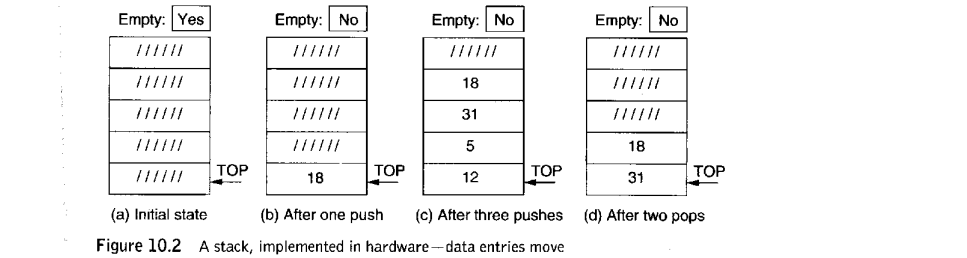

The coin holder is an example of a stack, precisely because it obeys the LIFO requirement. Each time you insert a quarter, you do so at the top. Each time you remove a quarter, you do so from the top. The last coin you inserted is the first coin you remove; therefore, it is a stack. 

Another implementation of a stack, sometimes referred to as a hardware stack, is shown in **Figure 10.2**. 
- Its behavior resembles that of the coin holder we just described. 
- It consists of some number of registers, each of which can store an element.

The example of Figure 10.2 contains five registers. As each element is added to the stack or removed from the stack, the elements already on the stack move. 

In Figure 10.2a, the stack is initially shown as empty. Access is always via the first element, which is labeled TOP. If the value 18 is pushed on to the stack, we have Figure 10.2b. If the three values, 31,5, and 12, are pushed (in that order), the result is Figure 10.2c. Finally, if two elements are popped from the stack, we have Figure 10.2d. 

The distinguishing feature of the stack of Figure 10.2 is that, like the quarters in the coin holder, as each value is added or removed, all the values already on the stack move. 

### 10.1.3 Implementation in Memory 
By far the most common implementation of a stack in a computer is as shown in Figure 10.3.

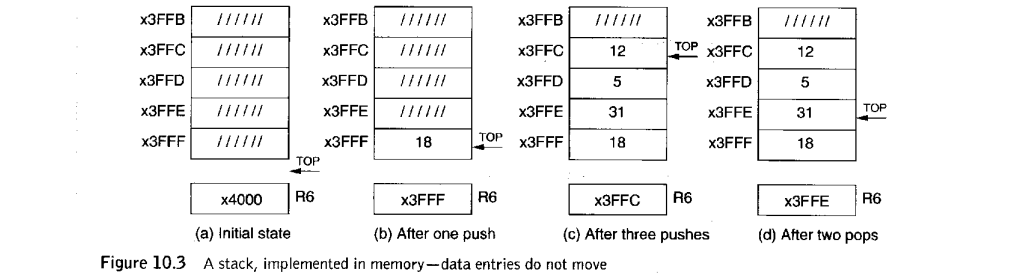

The stack consists of a sequence of memory locations along with a mechanism, called the stack pointer, that keeps track of the top of the stack, that is, the location containing the most recent element pushed.

Each value pushed is stored in one of the memory locations. **In this case, the data already stored on the stack does not physically move**. 

In the example shown in Figure 10.3, the stack consists of five locations, x3FFF through x3FFB. R6 is the stack pointer. 

#### Push
When we push a value onto the stack, the stack pointer is decremented and the value stored. The two-instruction sequence
    
    PUSH    ADD  R6,R6,#-1
            STR  R0,R6,#0 

pushes the value contained in R0 onto the stack.

#### Pop
To pop a value from the stack, the value is read and the stack pointer is incremented.

The following two-instruction sequence
    
    POP    LDR R0,R6,#0
           ADD R6,R6,#1

pops the value contained in the top of the stack and loads it into R0. 

#### Underflow 
What happens if we now attempt to pop three values from the stack when only two values remain on the stack -> problem

Attempting to pop items that have not been previously pushed results in an **underflow** situation

In our example, we can test for underflow by comparing the stack pointer with x4000, which would be the contents of R6 if there were nothing left on the stack to pop.

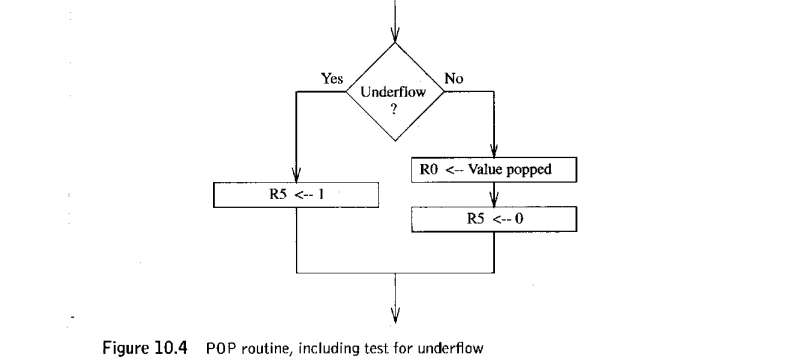

Upon return from the POP routine, the calling program would examine R5 to determine whether the POP completed successfully (R5 = 0), or not (R5 = 1). 

#### Overflow
What happens when we run out of available space and we try to push a value onto the stack? 

Since we cannot store values where there is no room, we have an overflow situation.

We can test for overflow by comparing the stack pointer with (in the example of Figure 10.3) x3FFB.
- If they are equal, we have no room to push another value onto the stack.

In the same way that it is useful to have the POP routine return to the calling program with success/failure information, rather than immediately jumping to the UNDERFLOW routine, it is useful to have the PUSH routine act similarly. 

We augment the PUSH routine with instructions to store 0 (success) or 1 (failure) in R5, depending on whether or not the push completed successfully. Upon return from the PUSH routine, the calling program would examine R5 to determine whether the PUSH completed successfully (R5 = 0) or not (R5 - 1).

### 10.1.4 The Complete Picture 
The POP and PUSH routines allow us to use memory locations x3FFF through x3FFB as a five-entry stack. 
- If we wish to push a value onto the stack, we simply load that value into RO and execute JSR PUSH.
- To pop a value from the stack into RO, we simply execute JSR POP. 
- If we wish to change the location or the size of the stack, we adjust BASE and MAX accordingly.

## 10.2 Inrerrupt-Driven I/O [Part 2]
Recall our discussion in Section 8.1.4 about interrupt-driven I/O as an alternative
to polling. As you know, in polling, the processor wastes its time spinning its
wheels, re-executing again and again the LDI and BR instructions until the Ready
bit is set. With interrupt-driven I/O, none of that testing and branching has to go
on. Instead, the processor spends its time doing what is hopefully useful work,
executing some program, until it is notified that some I/O device needs attention.

You remember that there are two parts to interrupt-driven I/O:
1. the enabling mechanism that allows an I/O device to interrupt the processor when it has input to deliver or is ready to accept output
2. the process that manages the transfer of the I/O data.

We showed that if the interrupt request signal is at a higher priority level (PL) than the PL of the currently executing process, the INT signal is asserted.

The actual management of the I/O data transfer goes through three stages:
1. Initiate the interrupt.
2. Service the interrupt.
3. Return from the interrupt.
We will discuss these in turn. 

### 10.2.1 Initiate and Service the Interrupt 
Recall: an interrupt is initiated because an I/O device with higher priority than the currently running program has caused the INT signal to be asserted

The processor, for its part, tests for the presence of
INT each time it completes an instruction cycle. If the test is negative, business
continues as usual and the next instruction of the currently running program is
fetched. If the test is positive, that next instruction is not fetched.
Instead, preparation is made to interrupt the program that is running and
execute the interrupt service routine that deals with the needs of the I/O device
that has requested this higher priority service. Two steps must be carried out:
(1) Enough of the state of the program that is running must be saved so we can
later continue where we left off, and (2) enough of the state of the interrupt service
routine must be loaded so we can begin to service the interrupt request. 

#### The State of a Program 
The state of a program is a snapshot of the contents of all the resources that the program affects
- It includes the contents of the memory locations that are part of the program and the contents of all the general purpose registers
- It also includes two very important registers, the **PC** and the **PSR**. 

The PC you are very familiar with; it contains the address of the next instruction to be executed. 

The **PSR**, shown here, is the **Processor Status Register**. It contains several important pieces of information about the status of the running program. 

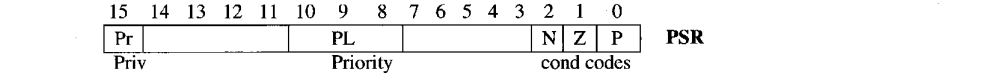

PSR[15] indicates whether the program is running in **privileged** (supervisor) or unprivileged (user) mode. 

PSR[10:8] specifies the priority level (**PL**) or sense of urgency of the execution of the program.

#### Saving the State of the Interrupted Program 
- **Saved State Information:**
  - **PC (Program Counter):** Tracks the next instruction for resumption.
  - **PSR (Processor Status Register):**
    - **Condition Codes (N, Z, P):** Needed for conditional branching.
    - **Priority Level:** Determines the program's urgency compared to others.
    - **Privilege Level:** Defines what resources the program can access.
- **What is not saved?**
  - General-purpose registers (service routines manage saving/restoring them).
- **Supervisor Stack:**
  - Dedicated to privileged mode programs.
  - Separate from the **User Stack**.
  - **R6 (Stack Pointer):** Functions as either:
    - **Supervisor Stack Pointer** in privileged mode.
    - **User Stack Pointer** in user mode.
  - **Saved.SSP and Saved.USP:** Store inactive stack pointers during privilege mode changes.

#### Loading the State of the Interrupt Service Routine
- **Interrupt Service Routine (ISR):**
  - Similar to trap service routines.
  - Stored in predefined memory locations.
- **Vectored Interrupts:**
  - **INTV (Interrupt Vector):** 
    - 8-bit value provided by the requesting device.
    - Expanded to a 16-bit address pointing to the ISR in the **Interrupt Vector Table**.
- **Loading the PSR:**
  - **PSR[2:0]:** Initially set to 0 (no executed instructions yet).
  - **PSR[15]:** Set to 0 (privileged mode).
  - **PSR[10:8]:** Set to the priority level of the interrupt request.

#### Servicing the Interrupt
- The PC now points to the starting address of the ISR.
- Example: A keyboard interrupt copies data from the keyboard’s data register into a specific memory location.

### 10.2.2 Return from the Interrupt 
**The last instruction in every interrupt service routine is `RTI`, return from interrupt.**

When the processor finally accesses the RTI instruction, all the requirements of the I/O device have been taken care of.

Execution of the RTI instruction (opcode = 1000) consists simply of popping the PSR and the PC from the Supervisor Stack (where they have been resting
peacefully) and restoring them to their rightful places in the processor.

The condition codes are now restored to what they were when the program was interrupted, in case they are needed by a subsequent BR instruction in the program.

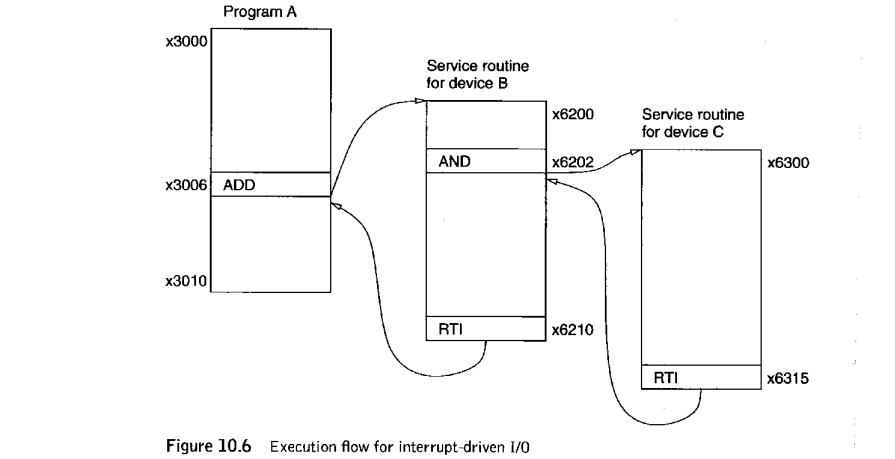

### 10.2.3 An Example 
We complete the discussion of interrupt-driven I/O with an example. Suppose program A is executing when I/O device B, having a PL higher than that of A, requests service. During the execution of the service routine for I/O device B, a still more urgent device C requests service.

**Figure 10.6** shows the execution flow that must take place. 


Let us examine the order of execution by the processor. **Figure 10.7** shows several snapshots of the contents of the Supervisor Stack and the PC during the execution of this example.

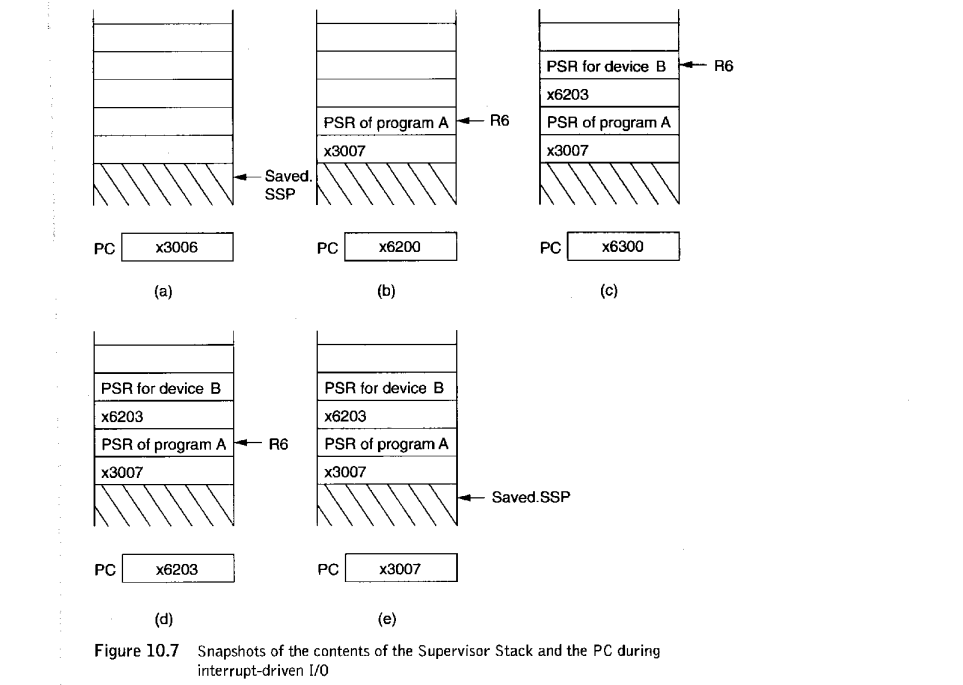

## 10.3 Arithmetic Using a Stock
### 10.3.1 The Stack as Temporary Storage
There are computers that use a stack instead of general purpose registers to store temporary values during a computation. 

Recall that our `ADD` instruction: `ADD    RO,Rl,R2 ` takes source operands from Rl and R2 and writes the result of the addition into RO

We call the LC-3 a **three-address machine** because all three locations (the two sources and the destination) are explicitly identified.

Some computers use a stack for source and destination operands and explicitly identify none of them. The instruction would simply be: `ADD`

We call such a computer a **stack machine**, or a **zero-address machine**.
- The hardware would know that the source operands are the top two elements on the stack, which would be popped and then supplied to the ALU, and that the result of the addition would be pushed onto the stack.
- To perform an ADD on a stack machine, the hardware would execute two pops, an add, and a push.
-  The two pops would remove the two source operands from the stack, the add would compute their sum, and the push would place the result back on the stack.

Sometimes (as we will see in our final example of this chapter), it is useful to process arithmetic using a stack. Intermediate values are maintained on the stack rather than in general purpose registers, such as the LC-3's RO through R7.

Most general purpose microprocessors, including the LC-3, use general purpose registers. Most calculators use a stack. 

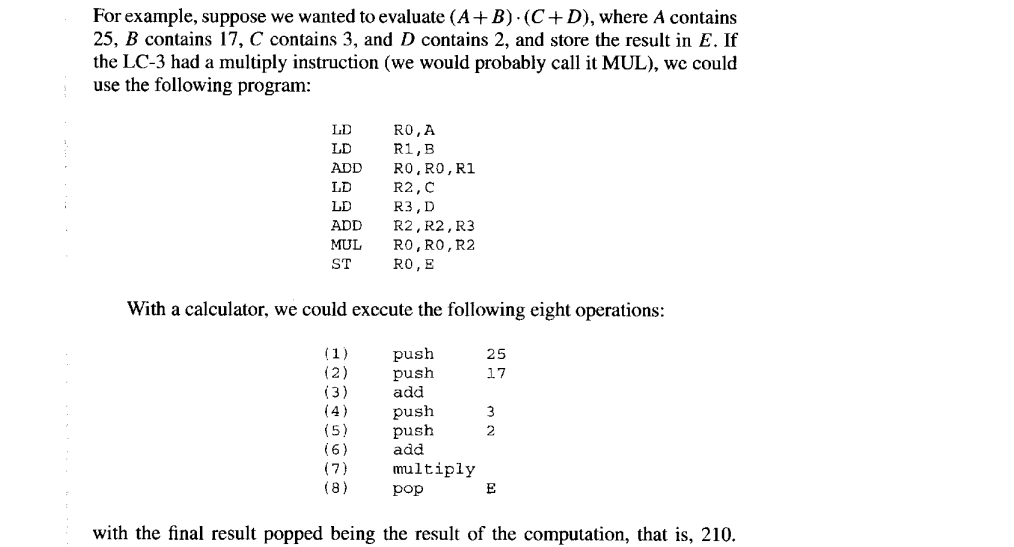

let's examine the subroutines we need to conduct the various arithmetic operations. 
### 10.3.3 OpAdd, OpMult, and OpNeg
The calculator we simulate in Section 10.5 has the ability to enter values, add, subtract, multiply, and display results. 

To add, subtract, and multiply, we need three subroutines:
1. OpAdd, which will pop two values from the stack, add them, and push the result onto the stack.
2. OpMult, which will pop two values from the stack, multiply them, and push the result onto the stack.
3. OpNeg, which will pop the top value, form its 2's complement negative value, and push the result onto the stack.

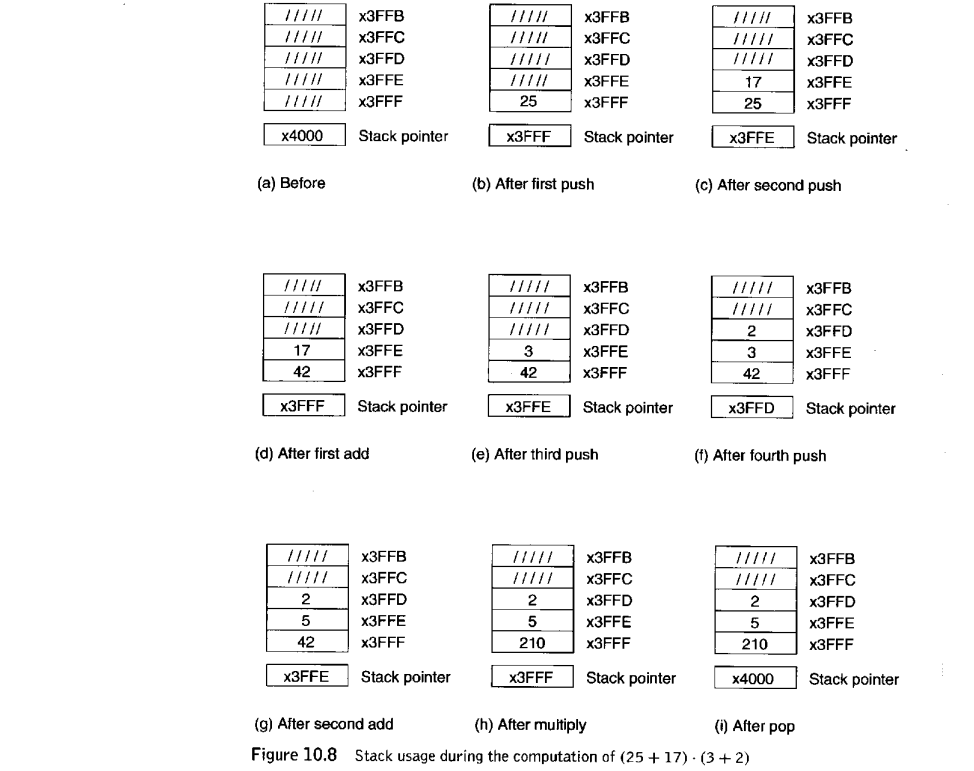

#### The OpAdd Algorithm 
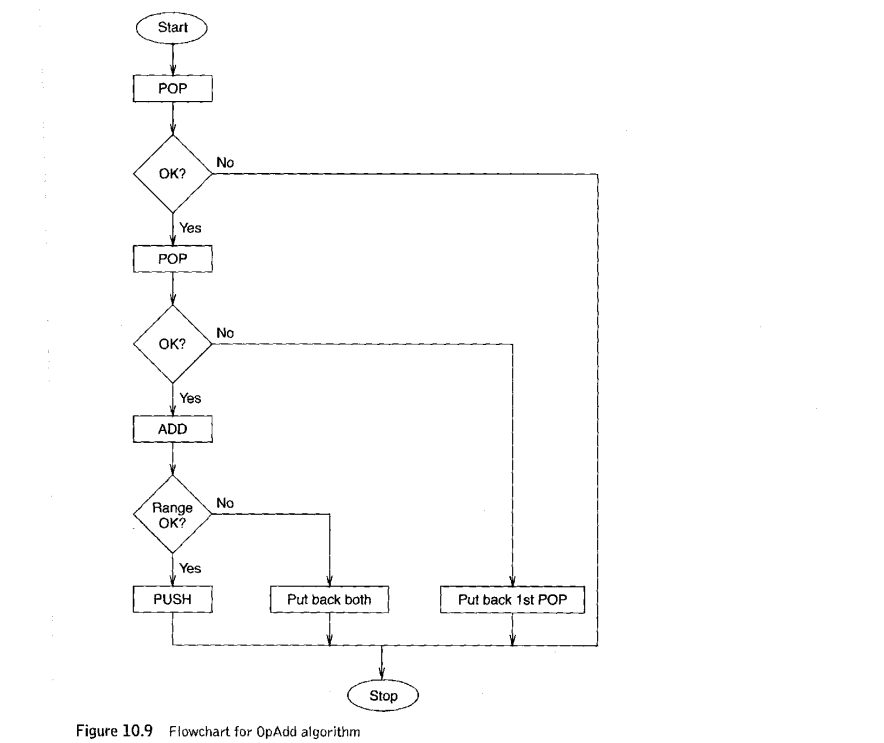

There are two things that could prevent the OpAdd algorithm from completing successfully: Fewer than two values are available on the stack for source operands,or the result is out of range. In both cases, the stack is put back to the way it was at the start of the OpAdd algorithm, a 1 is stored in R5 to indicate failure, and control is returned to the calling program. 

#### The OpMult Algorithm
Figure 10.13 shows the flowchart of the OpMult algorithm, and Figure 10.14 shows the LC-3 program that implements that algorithm. Similar to the OpAdd algorithm, the OpMult algorithm attempts to pop two values off the stack and, if successful, multiplies them.



## 10.4 Data Type Conversion 
We have been exposed to several data types: unsigned integers for address arithmetic, 2's complement integers for integer arithmetic, 16-bit binary strings for logical operations, floating point numbers for scientific computation, and ASCII codes for interaction with input and output devices. 

**It is important that every instruction be provided with source operands of the data type that the instruction requires.** 

For example, ADD requires operands that are 2's complement integers. If the ALU were supplied with floating point operands, the computer would produce garbage results.

### 10.4.1 Example: The Bogus Program: 2 + 3 = e
First, let's examine Figure 10.16, a concrete example of how one can get into
trouble if one is not careful about keeping track of the data type of each of the
values with which one is working.

Suppose we wish to enter two digits from the keyboard, add them, and display the results on the monitor. At first blush, we write the simple program of Figure 10.16. What happens? 

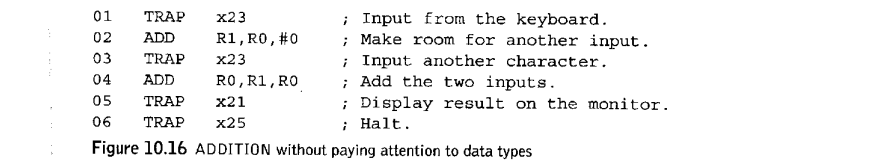

Suppose the first digit entered via the keyboard is a 2 and the second digit entered via the keyboard is a 3. What will be displayed on the monitor before the program terminates? The value loaded into RO as a result of entering a 2 is the ASCII code for 2, which is x0032. When the 3 is entered, the ASCII code for 3, which is x0033, will be loaded. Thus, the ADD instruction will add the two binary strings x0032 and x0033, producing x0065. When that value is displayed on the monitor, it will be treated as an ASCII code. Since x0065 is the ASCII code for a lowercase e, that is what will be displayed on the monitor.

## 10.5 Our Final Example: The Calculator
You are encouraged to study this example before moving on to Chapter 11 and High-Level Language Programming

**The calculator works as follows:**
- We use the keyboard to input commands and decimal values. 
- We use the monitor to display results. 
- We use a stack to perform arithmetic operations as described in Section 10.2.

**The available operations are:**
- `X` Exit the simulation.
- `D` Display the value at the top of the stack.
- `C` Clear all values from the stack.
- `+` Replace the top two elements on the stack with their sum.
- `*` Replace the top two elements on the stack with their product.
- `-` Negate the top element on the stack.
- `Enter` Push the value typed on the keyboard onto the top of the stack. 

Figure 10.21 is a flowchart that gives an overview of our calculator simulation. 

Simulation of the calculator starts with initialization, which includes setting R6, the stack pointer, to an empty stack. Then the user sitting at the keyboard is prompted for input.

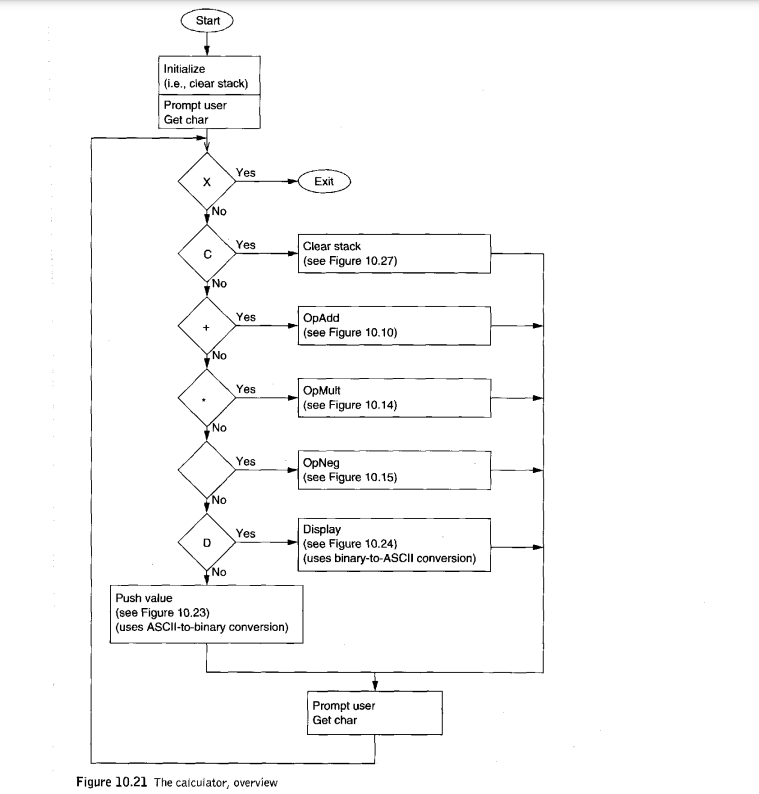

